In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage

df = pd.read_csv("/Users/calvi/Downloads/Mall_Customers.csv")
df.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [2]:
df.info()
df.describe()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

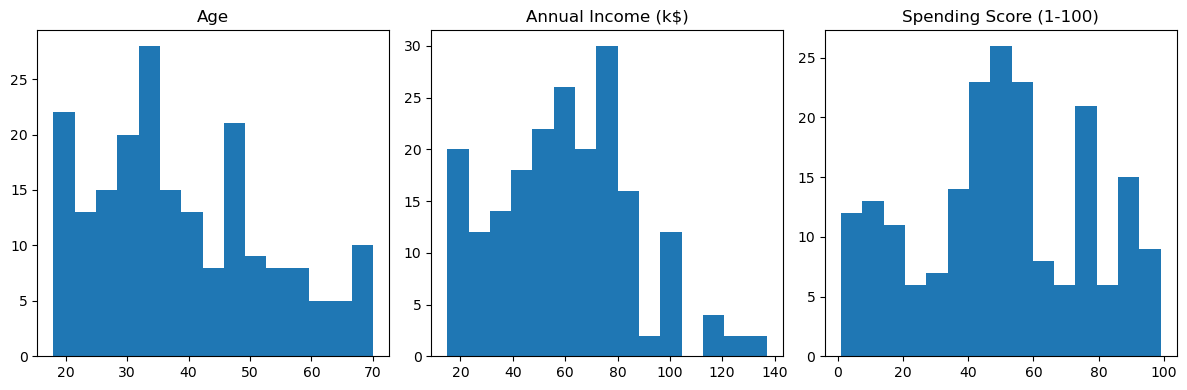

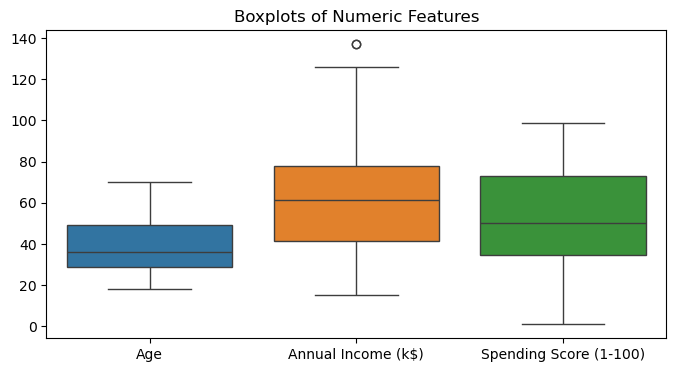

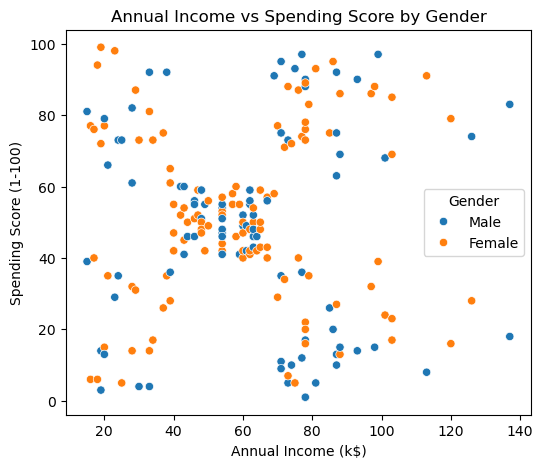

In [3]:
# Histograms
num_cols = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]

plt.figure(figsize=(12, 4))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    plt.hist(df[col], bins=15)
    plt.title(col)
plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(8, 4))
sns.boxplot(data=df[num_cols])
plt.title("Boxplots of Numeric Features")
plt.show()

# Scatter: Income vs Spending Score
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df,
    x="Annual Income (k$)",
    y="Spending Score (1-100)",
    hue="Gender"
)
plt.title("Annual Income vs Spending Score by Gender")
plt.show()


In [4]:
# Drop ID
df_proc = df.drop(columns=["CustomerID"])

# Encode Gender
le = LabelEncoder()
df_proc["Gender"] = le.fit_transform(df_proc["Gender"])

# Choose features for clustering
features_full = ["Gender", "Age", "Annual Income (k$)", "Spending Score (1-100)"]
X_full = df_proc[features_full].copy()

features_2d = ["Annual Income (k$)", "Spending Score (1-100)"]
X_2d = df_proc[features_2d].copy()

# Scale features
scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(X_full)

scaler_2d = StandardScaler()
X_2d_scaled = scaler_2d.fit_transform(X_2d)

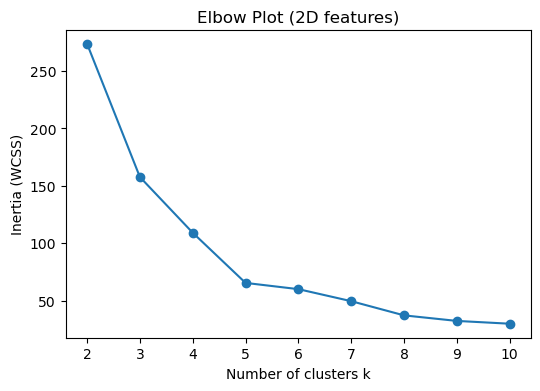

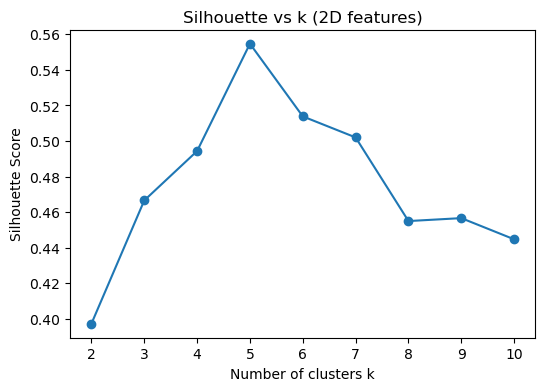

In [5]:
inertias = []
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_2d_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_2d_scaled, labels))

# Elbow plot
plt.figure(figsize=(6, 4))
plt.plot(k_range, inertias, marker="o")
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Plot (2D features)")
plt.show()

# Silhouette plot
plt.figure(figsize=(6, 4))
plt.plot(k_range, sil_scores, marker="o")
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette vs k (2D features)")
plt.show()

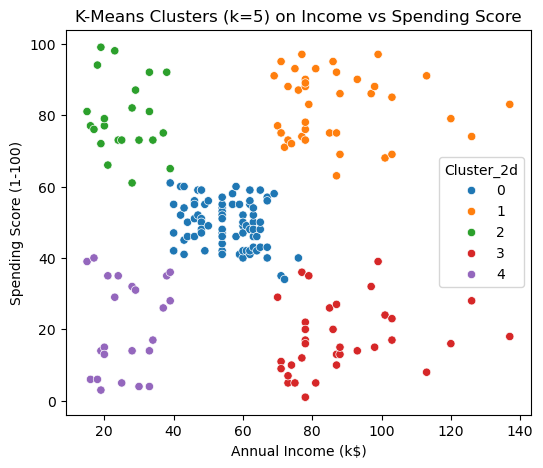

array([[55.2962963 , 49.51851852],
       [86.53846154, 82.12820513],
       [25.72727273, 79.36363636],
       [88.2       , 17.11428571],
       [26.30434783, 20.91304348]])

In [6]:
k_final = 5  # or 4 – set after looking at elbow/silhouette
kmeans_2d = KMeans(n_clusters=k_final, random_state=42, n_init="auto")
df["Cluster_2d"] = kmeans_2d.fit_predict(X_2d_scaled)

# Visualize clusters
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df,
    x="Annual Income (k$)",
    y="Spending Score (1-100)",
    hue="Cluster_2d",
    palette="tab10"
)
plt.title(f"K-Means Clusters (k={k_final}) on Income vs Spending Score")
plt.show()

# Cluster centers (original scale)
centers_2d_scaled = kmeans_2d.cluster_centers_
centers_2d = scaler_2d.inverse_transform(centers_2d_scaled)
centers_2d


In [7]:
k_final_full = k_final  # keep same k for consistency
kmeans_full = KMeans(n_clusters=k_final_full, random_state=42, n_init="auto")
df["Cluster_full"] = kmeans_full.fit_predict(X_full_scaled)

# Inspect cluster centers (scaled)
centers_full_scaled = kmeans_full.cluster_centers_
centers_full = pd.DataFrame(
    scaler_full.inverse_transform(centers_full_scaled),
    columns=features_full
)
centers_full


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,5.098039e-01,56.470588,46.098039,39.313725
1,1.000000e+00,39.500000,85.150000,14.050000
2,1.000000e+00,28.690476,60.904762,70.238095
3,-1.665335e-16,37.897959,82.122449,54.448980
4,1.665335e-16,27.315789,38.842105,56.210526


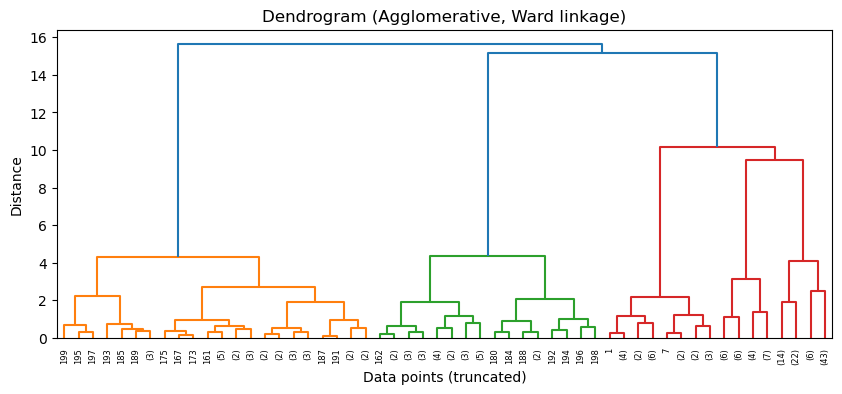

In [8]:
# Linkage for dendrogram (2D for visualization)
Z = linkage(X_2d_scaled, method="ward")

plt.figure(figsize=(10, 4))
dendrogram(Z, truncate_mode="level", p=5)
plt.title("Dendrogram (Agglomerative, Ward linkage)")
plt.xlabel("Data points (truncated)")
plt.ylabel("Distance")
plt.show()

# Agglomerative clustering with same k
agg = AgglomerativeClustering(n_clusters=k_final, linkage="ward")
df["Cluster_agg_2d"] = agg.fit_predict(X_2d_scaled)


In [10]:
cluster_summary = df.groupby("Cluster_full")[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].mean().round(1)
cluster_counts = df["Cluster_full"].value_counts().sort_index()

cluster_summary["Count"] = cluster_counts
cluster_summary


,Age,Annual Income (k$),Spending Score (1-100),Count
Cluster_full,,,,
0,56.5,46.1,39.3,51
1,39.5,85.2,14.0,20
2,28.7,60.9,70.2,42
3,37.9,82.1,54.4,49
4,27.3,38.8,56.2,38
